<a href="https://colab.research.google.com/github/sangttruong/pensa/blob/master/PENSA_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

The target of this analysis is G protein-coupled receptor or GPCR. The structure of GPCR is reported by  [*Huang et al (2015*) ](https://www.nature.com/articles/nature14886).

<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Beta-2-adrenergic-receptor.png" width="200">
</p>

The information about trajectory from molecular dynamic simulation for this tutorial is available online at [GPCRmd](https://www.nature.com/articles/s41592-020-0884-y). More information about dynamic and kinetic of morphine binding to $\mu$-Opioid Receptor is reported in [*Kapoor et al 2017*](https://www.nature.com/articles/s41598-017-11483-8) 

# PENSA Tutorial
Here we show some common functions included in PENSA.

The example system is the G protein-coupled receptor rhodopsin, once bound to arrestin-1 and once bound to Gi. 
We are going to compare the structural ensemble of the receptor.

This tutorial assumes that you have access to the respective simulation trajectories on Sherlock. If you don't, just use any other system you like and adapt the file names and residue selections accordingly.

We only need to import the module "os" and all functions from PENSA itself which in turn loads all the modules it needs.

In [ ]:
# File system functions
import os
from google.colab import drive
drive.mount('/content/gdrive')
# PENSA functions
!pip install pensa
from pensa import *
root_dir = "gdrive/My Drive/Colab Notebooks/pensa/"

## Preprocessing 

To work with the protein coordinates, we first need to extract them from the simulation, i.e., remove the solvent, lipids etc. and write them in the .xtc format that the internal featurization understands. This is the hardest part but you usually only have to do it once and can then play with your data. Preprocessing can handle many common trajectory formats (as it is based on MDAnalysis) but the internal featurization (based on PyEMMA) is a bit more restrictive. For large trajectories, you might want to use the scripts provided in the PENSA repository, e.g., to run them on the computing cluster and then download the processed data.

In the following, we define the necessary files. For each simulation, we need a reference file (.psf for AMBER), a PDB file, and the trajetory. 

Make sure to adapt the root directory such that it links to wherever you have mounted Oak. I you cannot access the Sherlock cluster at Stanford, use any other simulation that you would like to compare. 

To run this tutorial on another system, you'll have to adapt the file paths and names in the following box and, in case you need them, the residue selections in the folder ```selections```. We explain them further below.

In [ ]:
# Simulation A
ref_file_a = root_dir+"11882_dyn_199.psf"
pdb_file_a = root_dir+"11880_dyn_199.pdb"
trj_file_a = root_dir+"11888_trj_199.xtc"

# Simulation B
ref_file_b = root_dir+"11900_dyn_201.psf"
pdb_file_b = root_dir+"11899_dyn_201.pdb"
trj_file_b = root_dir+"11897_trj_201.xtc"

# Base for the selection string for each simulation
# sel_base_a = "protein and segid P229"
# sel_base_b = "protein and segid P3"
sel_base_a = "protein"
sel_base_b = "protein"

# Names of the output files - Previous output
# out_name_a = "traj/rhodopsin_arrbound"
# out_name_b = "traj/rhodopsin_gibound"
# out_name_combined="traj/rhodopsin_combined"
out_name_a = root_dir+"traj/rhodopsin_arrbound"
out_name_b = root_dir+"traj/rhodopsin_gibound"
out_name_combined= root_dir+"rhodopsin_combined"

For this tutorial, we will save the processed trajectories in the subfolder ```traj```. We also create subfolders for other results that we will generate.

In [ ]:
# Still not working in Colab
# os.chdir(path)
for subdir in ['traj','plots','vispdb','pca','clusters','results']:
    if not os.path.exists(subdir):
        os.makedirs(root_dir + subdir)

We have to ensure that from both simulations, we use the exact same parts of the receptor for the analysis. Often, this will be easy and you just provide a simple selection string for the corresponding segment. For more complicated cases, we can use the function ```load_selection()``` to generate a complete residue list from a plain text file. This file should provide in each line the first and the last residue to be considered for a part of the protein. 

In the first case, we will extract all residues that are present in both simulations. The residues are defined in the file ```selections/rho_receptor.txt```. 

In [ ]:
# Load the selection and generate the strings
# sel_string_a = load_selection(root_dir+"selections/rho_receptor.txt", sel_base_a+" and ")
# sel_string_b = load_selection(root_dir+"selections/rho_receptor.txt", sel_base_b+" and ")
sel_string_a = sel_string_b = "protein"

# Extract the coordinates of the receptor from the trajectory
extract_coordinates(ref_file_a, pdb_file_a, [trj_file_a], out_name_a+"_receptor", sel_string_a)
extract_coordinates(ref_file_b, pdb_file_b, [trj_file_b], out_name_b+"_receptor", sel_string_b)

/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


In many cases, you probably have several runs of the same simulation that you want to combine to one structural ensemble. This is why the trajectory argument takes a list as arguments, e.g.

    extract_coordinates(system.psf, system.pdb, ['run1.nc','run2.nc','run3.nc'], 
                        'rho_receptor', 'protein', start_frame=1000)
                                 
With the option ```start_frame```, you can exclude the equilibrium phase already at this stage. Be aware that in combined simulations, there is no straightforward way to exclude it later as it would require bookkeeping about how long each simulation was etc.

If you want to combine data from different simulation conditions, you can use the ```_combined``` version of the extraction function: ```extract_coordinates_combined()```. It takes lists as arguments for the topology files, too. To use the same selection, "multiply" a list of one string, e.g.

    extract_coordinates_combined([system1.psf, system2.psf, system3.psf],
                                 ['system1.nc','system2.nc','system3.nc'], 
                                 ['protein']*3, 
                                 processed.nc, 
                                 start_frame=1000)
                                 

For some analysis types, we only want to use the part of the receptor that is inside the membrane. In this way, very flexible loops outside the membrane cannot distort the analysis result. As we can see, the corresponding selection file ```selections/rho_tm.txt``` now has more lines because the selection is not one contiguous part of the sequence any more.

In [ ]:
# Load the selection and generate the strings
sel_string_a = load_selection(root_dir+"selections/rho_tm.txt", sel_base_a+" and ")
print('Selection A:\n', sel_string_a, '\n')
sel_string_b = load_selection(root_dir+"selections/rho_tm.txt", sel_base_b+" and ")
print('Selection B:\n', sel_string_b, '\n')
# Extract the coordinates of the transmembrane region from the trajectory
extract_coordinates(ref_file_a, pdb_file_a, [trj_file_a], out_name_a+"_tm", sel_string_a)
extract_coordinates(ref_file_b, pdb_file_b, [trj_file_b], out_name_b+"_tm", sel_string_b)

Selection A:
 protein and resid 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321  

Selection B:
 protein and resid 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 

/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


## Featurization

The analysis is not performed on the coordinates directly but on features derived from these coordinates.
PENSA uses the featurization provided by PyEMMA, so far including:
 - backbone torsions: ```'bb-torsions'```, 
 - backbone C-alpha distances: ```'bb-distances'```, and 
 - sidechain torsions: ```'sc-torsions'```.

You can combine these with any other function implemented in PyEMMA, even if it is not included in PENSA.

In case the equilibration phase has not been already excluded during preprocessing, we can exclude it here by setting the start frame to a value greater than 0.

In [ ]:
start_frame = 2000

The function ```get_features``` loads the names of the features and their values separately 

In [ ]:
rho_g_rec = get_features(root_dir+"traj/rhodopsin_gibound_receptor.gro", 
                         root_dir+"traj/rhodopsin_gibound_receptor.xtc", 
                         start_frame)
rho_g_rec_feat, rho_g_rec_data = rho_g_rec

/usr/local/lib/python3.6/dist-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]
/usr/local/lib/python3.6/dist-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


In [ ]:
rho_a_rec = get_features(root_dir+"traj/rhodopsin_arrbound_receptor.gro",
                         root_dir+"traj/rhodopsin_arrbound_receptor.xtc", 
                         start_frame)
rho_a_rec_feat, rho_a_rec_data = rho_a_rec

/usr/local/lib/python3.6/dist-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]
/usr/local/lib/python3.6/dist-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


Having a look at the shape of the loaded data, we see that the first dimension is the number of frames. The second dimension is the number of features. It must be the same for both simulations.

In [ ]:
for k in rho_g_rec_data.keys(): 
    print(k, rho_g_rec_data[k].shape)

bb-torsions (2587, 1152)
sc-torsions (2587, 1052)
bb-distances (2587, 41616)


In [ ]:
for k in rho_a_rec_data.keys(): 
    print(k, rho_a_rec_data[k].shape)

bb-torsions (10000, 1152)
sc-torsions (10000, 1052)
bb-distances (10000, 41616)


Now do the same only for the transmembrane region.

In [ ]:
rho_g_tmr = get_features(root_dir+"traj/rhodopsin_gibound_receptor.gro", 
                         root_dir+"traj/rhodopsin_gibound_receptor.xtc", 
                         start_frame)
rho_a_tmr = get_features(root_dir+"traj/rhodopsin_arrbound_receptor.gro", 
                         root_dir+"traj/rhodopsin_arrbound_receptor.xtc", 
                         start_frame)
rho_g_tmr_feat, rho_g_tmr_data = rho_g_tmr
rho_a_tmr_feat, rho_a_tmr_data = rho_a_tmr

/usr/local/lib/python3.6/dist-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]
/usr/local/lib/python3.6/dist-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


## Comparison of Structural Ensembles

Here we compare the two ensembles using measures for the relative entropy.

You can as well calculate the Kolmogorov-Smirnov metric and the corresponding p value using the function ```kolmogorov_smirnov_analysis()```. 

Another possibility is to compare only the means and standard deviations of the distributions using ```mean_difference_analysis()```.

### Backbone Torsions

We start with the backbone torsions, which we can select via ```'bb-torsions'```. To do the same analysis on sidechain torsions, replace ```'bb-torsions'``` with ```'sc-torsions'```.

In [ ]:
# Relative Entropy analysis with torsions
relen = relative_entropy_analysis(rho_a_rec_feat['bb-torsions'], 
                                  rho_g_rec_feat['bb-torsions'], 
                                  rho_a_rec_data['bb-torsions'], 
                                  rho_g_rec_data['bb-torsions'],
                                  bin_width=0.001, verbose=False)
names_bbtors, jsd_bbtors, kld_ag_bbtors, kld_ga_bbtors = relen 

The above function also returns the Kullback-Leibler divergences of A with respect to B and vice versa.

To find out where the ensembles differ the most, let's print out the most different features and the corresponding value.

In [ ]:
# Print the features with the 12 highest values
sf = sort_features(names_bbtors, jsd_bbtors)
for f in sf[:12]: print(f[0], f[1])

SIN(PSI 0 TRP 293) 0.5112877642162762
COS(PSI 0 TRP 293) 0.4944009903222728
COS(PSI 0 ARG 263) 0.47929220872083395
COS(PHI 0 TRP 293) 0.46504205891252787
SIN(PSI 0 SER 64) 0.45332462168803855
COS(PSI 0 SER 64) 0.4342354360522885
SIN(PSI 0 ARG 263) 0.43256393372048946
SIN(PHI 0 SER 268) 0.3429751153970617
COS(PSI 0 PRO 295) 0.33780578955315677
SIN(PSI 0 PRO 295) 0.3320260295168222
COS(PSI 0 SER 268) 0.33171663775349836
SIN(PSI 0 SER 261) 0.31237951176465373


To get an overview of how strongly the ensembles differ in which region, we can plot the maximum deviation of the features related to a certain residue.

/usr/local/lib/python3.6/dist-packages/MDAnalysis/lib/mdamath.py:247: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/usr/local/lib/python3.6/dist-packages/MDAnalysis/lib/mdamath.py:248: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/usr/local/lib/python3.6/dist-packages/MDAnalysis/lib/mdamath.py:249: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/usr/local/lib/python3.6/dist-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/usr/local/lib/python3.6/dist-packages/MDA

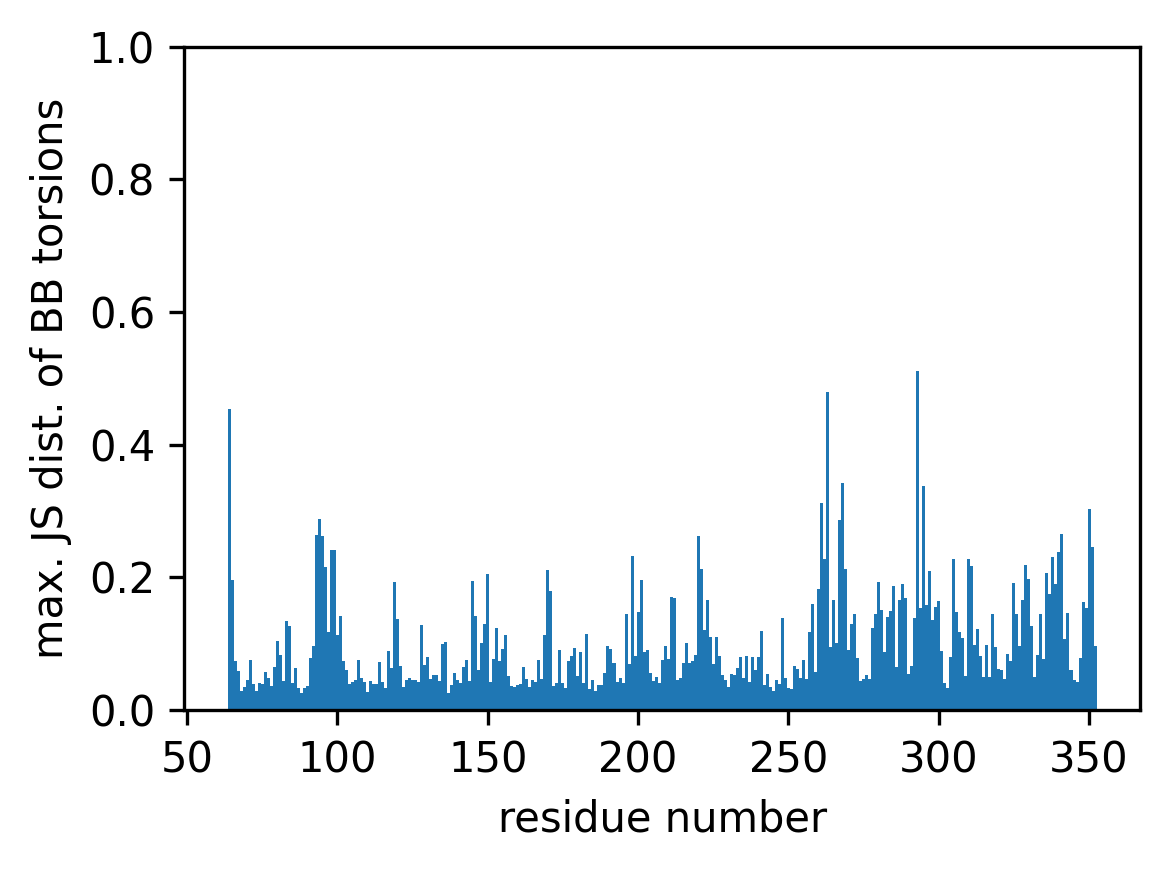

In [ ]:
# Plot the maximum Jensen-Shannon distance per residue as "B factor" in a PDB file
ref_filename = root_dir+"traj/rhodopsin_arrbound_receptor.gro"
out_filename = "rhodopsin_receptor_bbtors-deviations_tremd"
vis = residue_visualization(names_bbtors, jsd_bbtors, ref_filename, 
                            root_dir+"plots/"+out_filename+"_jsd.pdf", 
                            root_dir+"vispdb/"+out_filename+"_jsd.pdb",
                            y_label='max. JS dist. of BB torsions')


In [ ]:
# Save the corresponding data
np.savetxt(root_dir+'results/'+out_filename+'_relen.csv', 
           np.array(relen).T, fmt='%s', delimiter=',', 
           header='Name, JSD(A,B), KLD(A,B), KLD(B,A)')
np.savetxt(root_dir+'results/'+out_filename+'_jsd.csv', 
           np.array(vis).T, fmt='%s', delimiter=',', 
           header='Residue, max. JSD(A,B)')

### Backbone C-alpha Distances

Another common representation for the overall structure of a protein are the distances between the C-alpha atoms. We can perform the same analysis on them.

In [ ]:
# Relative entropy analysis for C-alpha distances
relen = relative_entropy_analysis(rho_a_rec_feat['bb-distances'], 
                                  rho_g_rec_feat['bb-distances'], 
                                  rho_a_rec_data['bb-distances'], 
                                  rho_g_rec_data['bb-distances'],
                                  bin_width=0.001, verbose=False)
names_bbdist, jsd_bbdist, kld_ag_bbdist, kld_ga_bbdist = relen 

In [ ]:
# Print the features with the 12 highest values
sf = sort_features(names_bbdist, jsd_bbdist)
for f in sf[:12]: print(f[0], f[1])

DIST: PHE 241 CA 2856 - GLY 325 CA 4279 0.644745694240557
DIST: PHE 241 CA 2856 - TYR 326 CA 4286 0.6343277249853825
DIST: TRP 293 CA 3739 - ASN 328 CA 4321 0.6025791478495596
DIST: TRP 293 CA 3739 - CYS 330 CA 4346 0.5948595923209611
DIST: TRP 293 CA 3739 - THR 327 CA 4307 0.5948060350650041
DIST: ASP 147 CA 1330 - ILE 296 CA 3791 0.5946201671453185
DIST: PHE 241 CA 2856 - THR 327 CA 4307 0.5870333863967021
DIST: TRP 293 CA 3739 - HIS 319 CA 4183 0.5856469805223292
DIST: TRP 293 CA 3739 - CYS 321 CA 4220 0.5822790520440968
DIST: MET 99 CA 576 - CYS 351 CA 4706 0.5819318087814229
DIST: ILE 146 CA 1311 - ILE 296 CA 3791 0.5808083074381543
DIST: TRP 293 CA 3739 - ALA 323 CA 4250 0.578659306249477


To visualize distances, we need a two-dimensional representation with the residues on each axis. 
We color each field with the value of the Jensen-Shannon distance (but could as well use Kullback-Leibler divergence, Kolmogorov-Smirnov statistic etc. instead).

Plotting distance matrix
first res: 64 , last res: 351


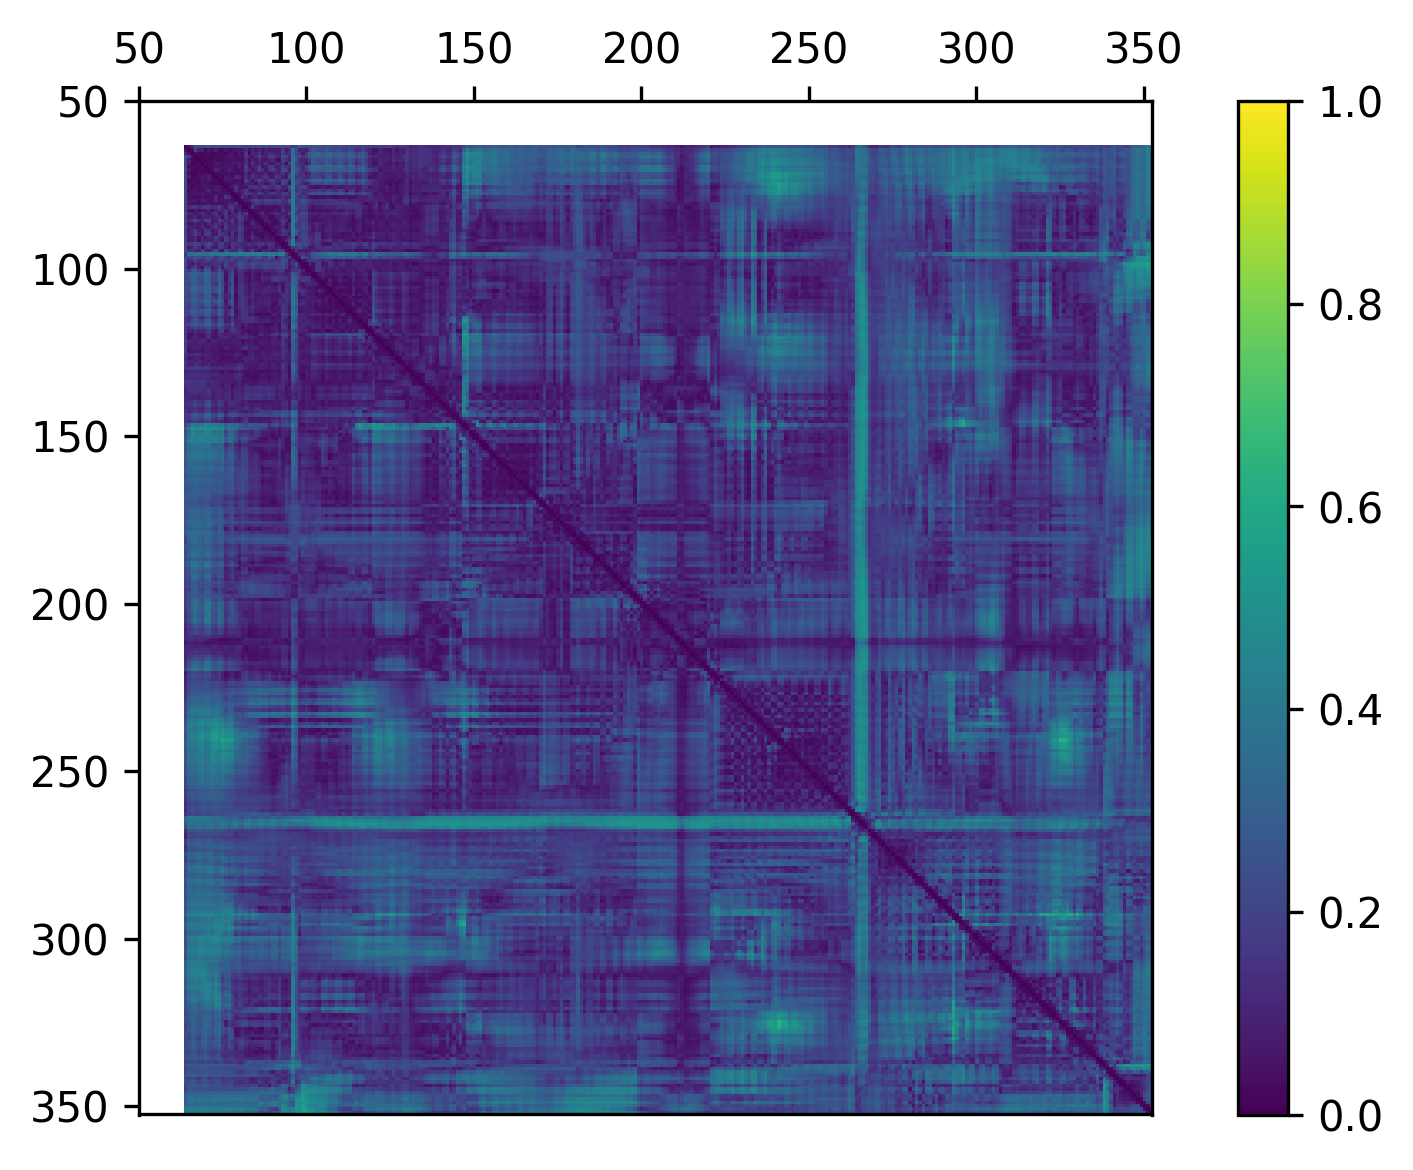

In [ ]:
# Visualize the deviations in a matrix plot
matrix = distances_visualization(names_bbdist, jsd_bbdist, 
                                 root_dir+"plots/rhodopsin_arrbound_jsd-bbdist.pdf",
                                 vmin = 0.0, vmax = 1.0)

## Principal Component Analysis

Here we show how to calculate the principal components in the space of backbone torsions. It is also common to calculate principal components in the space of backbone distances. For the latter, again just change ```'bb-torsions'``` to ```'bb-distances'```. As mentioned above, we only consider the transmembrane region here, so flexible loops outside the membrane do not distort the more important slow motions in the receptor core.

#### Combined PCA

In the spirit of comparing two simulations, we calculate the principal components of their joint ensemble of structures.

In [ ]:
# Combine the data of the different simulations
rho_combined_data_tors = np.concatenate([rho_g_tmr_data['bb-torsions'],rho_a_tmr_data['bb-torsions']],0)

We can now calculate the principal components of this combined dataset. The corresponding function returns a PyEMMA PCA object, so you can combine it with all functionality in PyEMMA to perform more advanced or specialized analysis.

In [ ]:
pca_combined = calculate_pca(rho_combined_data_tors)

To find out how relevant each PC is, let's have a look at their eigenvalues.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([2.14706829, 2.07525441, 1.68660384, 1.14806378, 1.0899846 ,
        1.03442598, 0.85656141, 0.75882021, 0.72429834, 0.62407589,
        0.55367294, 0.54150219]))

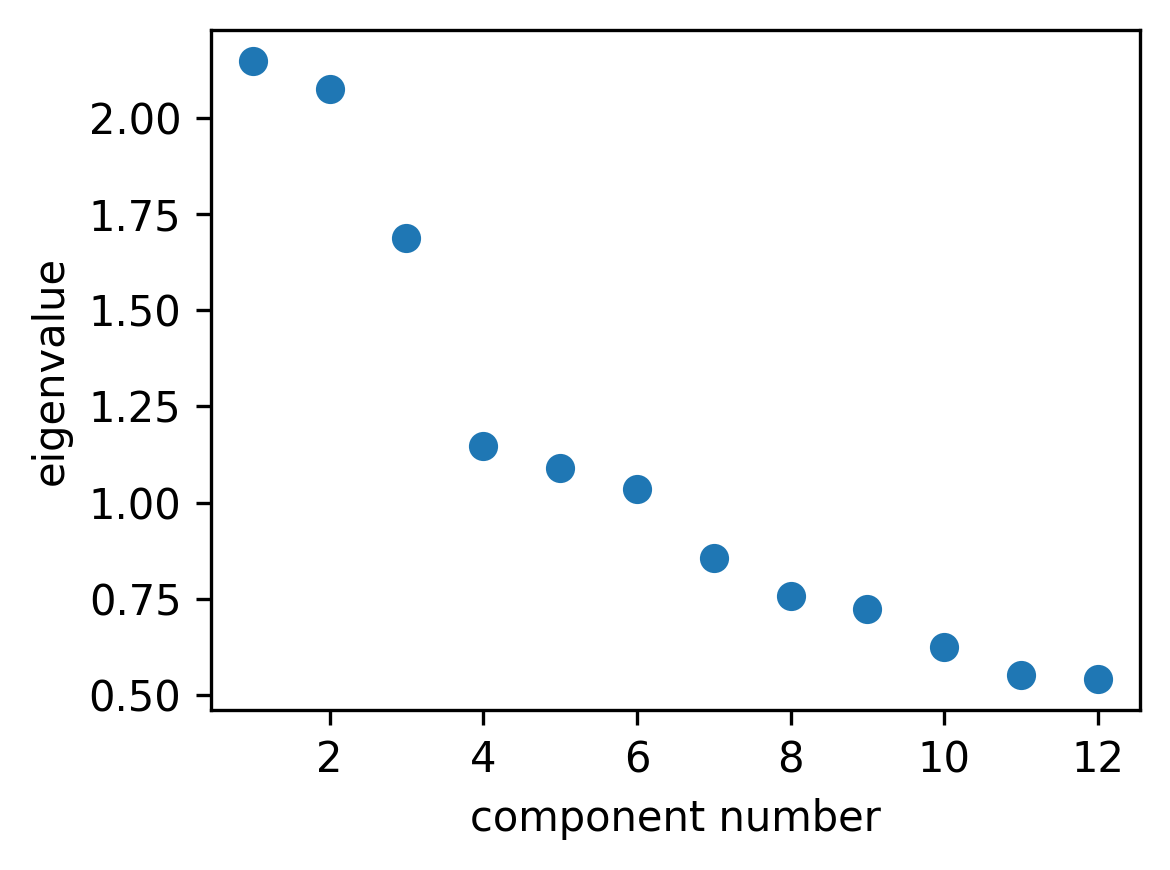

In [ ]:
pca_eigenvalues_plot(pca_combined, num=12, plot_file=root_dir+'plots/rhodopsin_combined_tmr_eigenvalues.pdf')

Let us now have a look at the most relevant features of the first three principal components. 
Here, we define a feature as important if its correlation with the respective PC is above a threshold of 0.4.
The function also plots the correlation analysis for each PC.

Features with abs. corr. above a threshold of 0.4 for PC 1:
COS(PSI 0 SER 261) -0.469
SIN(PSI 0 SER 261)  0.514
COS(PSI 0 VAL 262)  0.768
SIN(PSI 0 VAL 262) -0.697
COS(PSI 0 MET 265) -0.526
COS(PHI 0 SER 268) -0.410
COS(PSI 0 SER 268)  0.526
SIN(PSI 0 SER 268) -0.770
COS(PHI 0 ALA 337) -0.488
COS(PSI 0 ALA 337) -0.433
SIN(PSI 0 ALA 337) -0.413
Features with abs. corr. above a threshold of 0.4 for PC 2:
COS(PSI 0 SER 261)  0.471
COS(PSI 0 ARG 263)  0.765
SIN(PSI 0 ARG 263) -0.712
COS(PSI 0 MET 265)  0.460
SIN(PHI 0 GLY 267) -0.748
SIN(PHI 0 SER 268)  0.591
Features with abs. corr. above a threshold of 0.4 for PC 3:
COS(PSI 0 SER 64)  0.462
SIN(PSI 0 SER 64) -0.569
SIN(PHI 0 VAL 262)  0.689
COS(PHI 0 MET 265)  0.460
SIN(PHI 0 MET 265)  0.546
COS(PSI 0 ALA 264) -0.675
SIN(PSI 0 ALA 264)  0.499
COS(PSI 0 SER 268) -0.405
COS(PHI 0 TYR 336)  0.424
COS(PHI 0 ALA 337)  0.461
SIN(PSI 0 TYR 336) -0.449
COS(PSI 0 ALA 337)  0.416


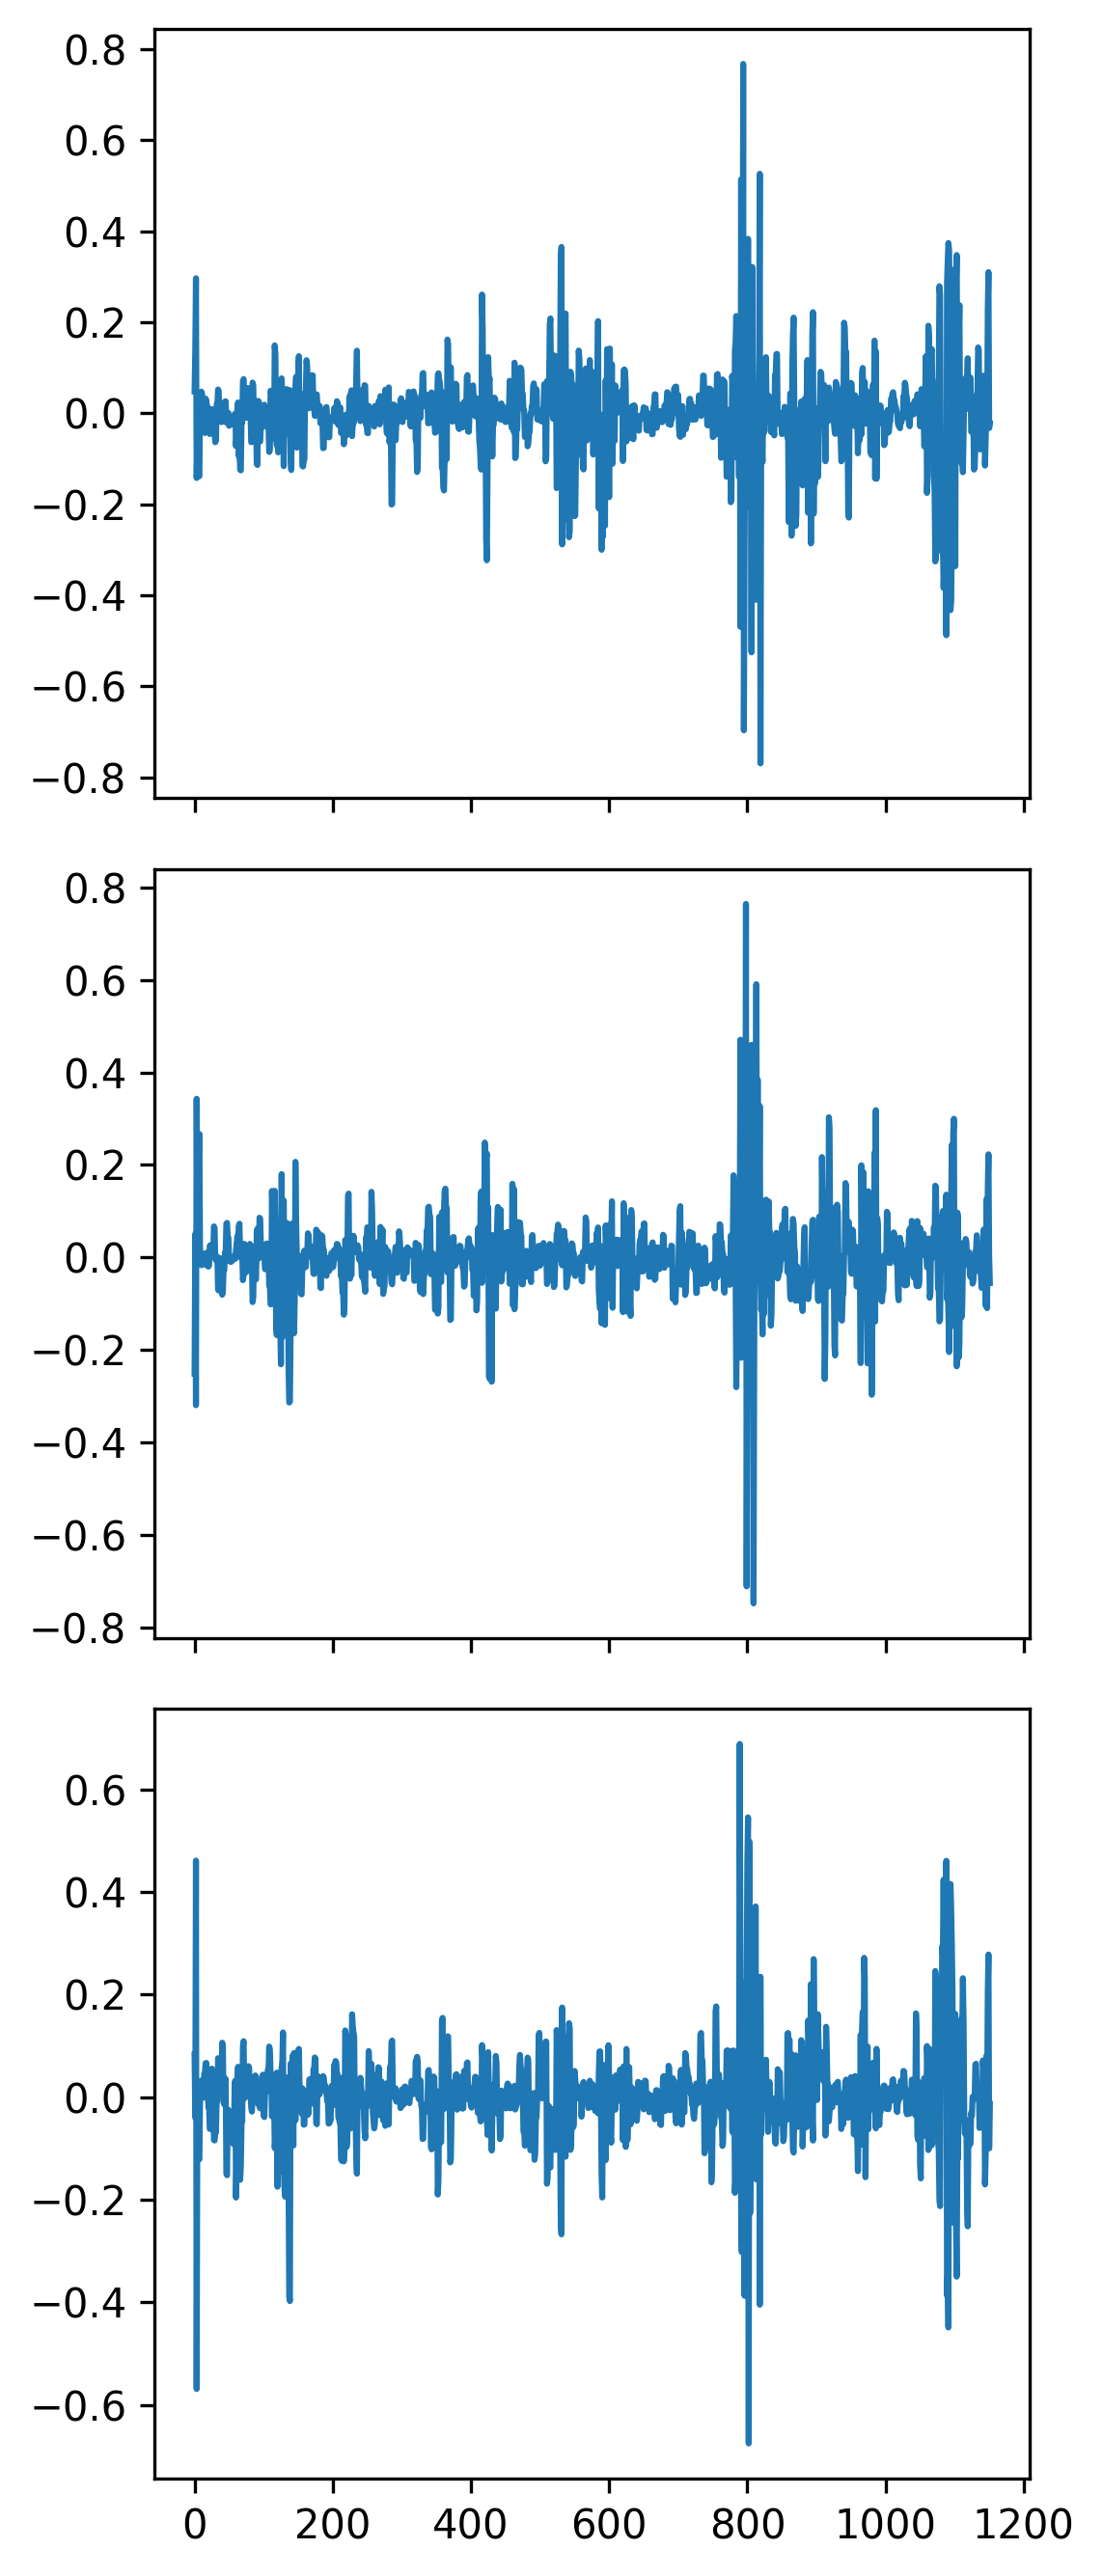

In [ ]:
pca_features(pca_combined,rho_g_tmr_feat['bb-torsions'].describe(), 3, 0.4)

Now we can compare how the frames of each ensemble are distributed along the principal components.

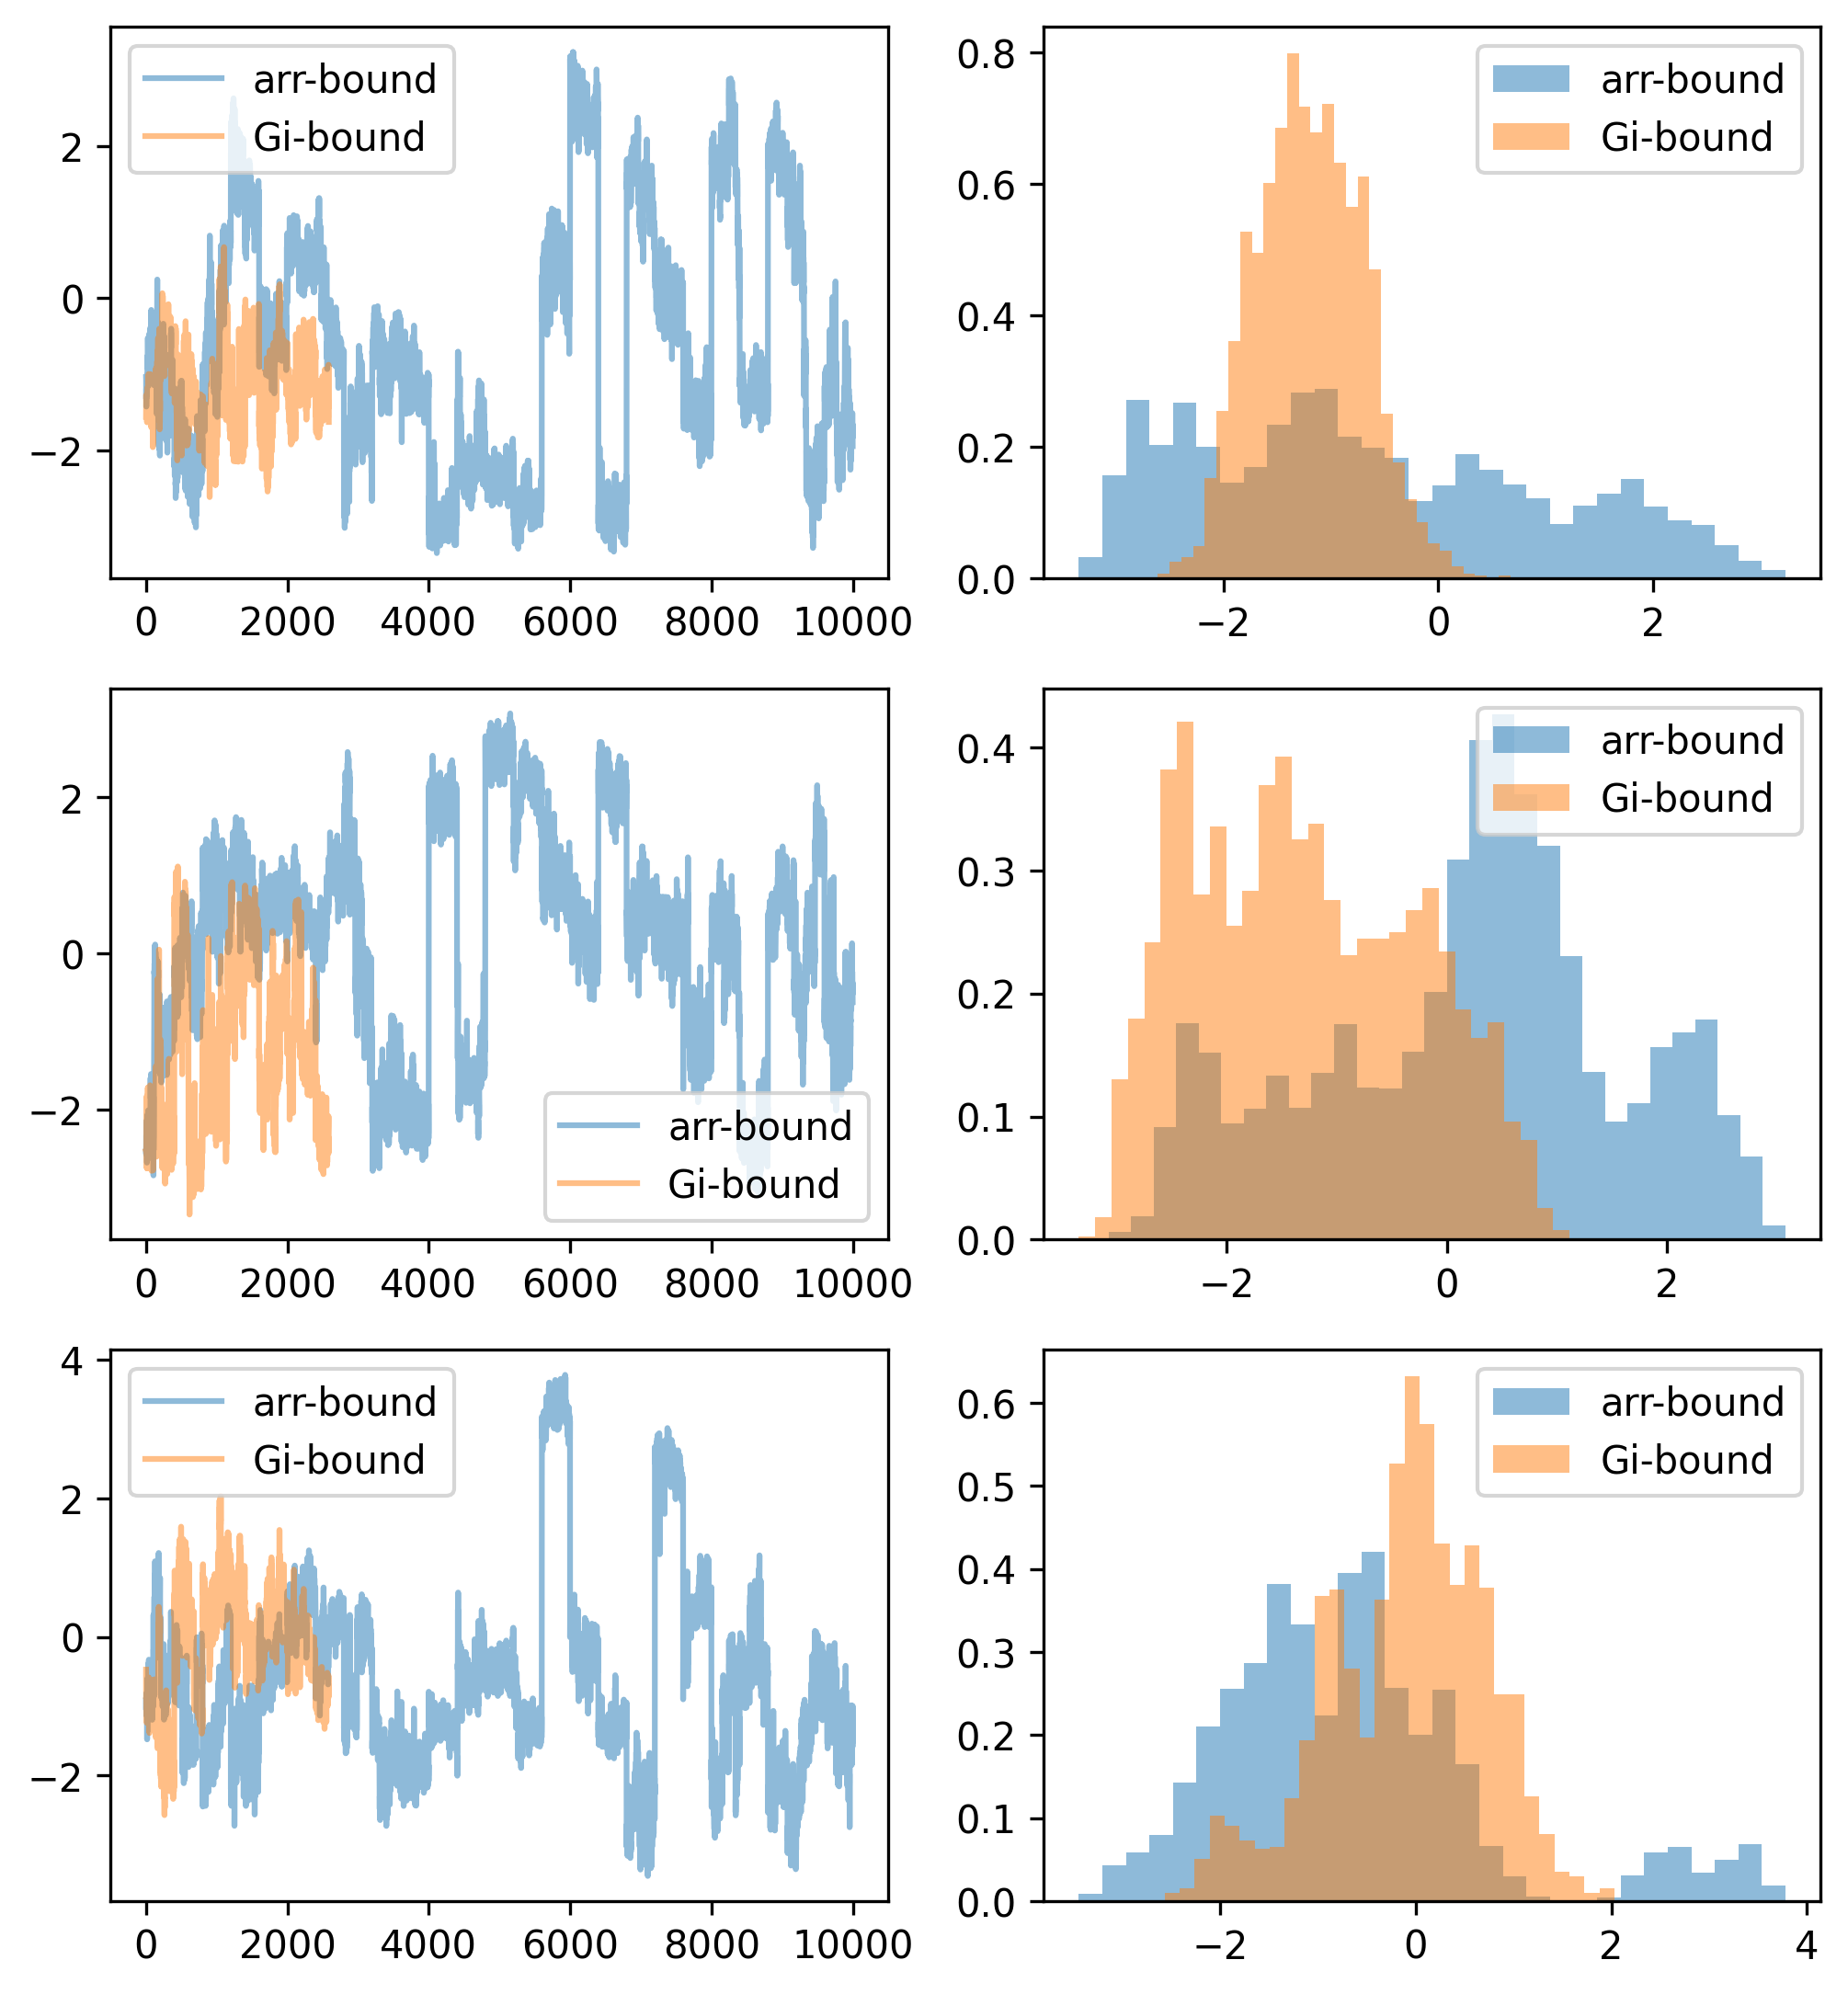

In [ ]:
compare_projections(rho_a_tmr_data['bb-torsions'],
                    rho_g_tmr_data['bb-torsions'],
                    pca_combined,
                    label_a='arr-bound', 
                    label_b='Gi-bound')

To get a better glimpse on what the Principal components look like, we would like to visualize them. 
For that purpose, let us sort the structures from the trajectories along the principal components instead of along simulation time.
We can then look at the resulting PC trajectories with a molecular visualization program like VMD.

The trajectory to be sorted does not have to be the same subsystem from which we calcualted the PCA. Here, we are going to write frames with the entire receptor, sorted by the PCs of the transmembrane region.

In [ ]:
sort_trajs_along_common_pc(rho_g_tmr_data['bb-torsions'],
                           rho_a_tmr_data['bb-torsions'],
                           start_frame,
                           root_dir+"traj/rhodopsin_gibound_receptor.gro",
                           root_dir+"traj/rhodopsin_arrbound_receptor.gro",
                           root_dir+"traj/rhodopsin_gibound_receptor.xtc",
                           root_dir+"traj/rhodopsin_arrbound_receptor.xtc",
                           root_dir+"pca/rhodopsin_receptor_by_tmr",
                           num_pc=3)

The above function deals with the special case of two input trajectories. We also provide the functions for a single one (see below). You use these to calculate PCA for any number of combined simulations and then sort the single or combined simulations.

#### Single simulation

Here are the major steps of a PCA demonstrated for a single simulation.

In [ ]:
pca_g = calculate_pca(rho_g_tmr_data['bb-torsions'])

Features with abs. corr. above a threshold of 0.4 for PC 1:
SIN(PSI 0 SER 64) -0.451
SIN(PHI 0 TYR 96)  0.492
COS(PSI 0 ARG 95) -0.448
SIN(PHI 0 GLY 136)  0.430
COS(PSI 0 PHE 135)  0.428
COS(PSI 0 SER 261) -0.407
SIN(PSI 0 SER 261)  0.436
COS(PSI 0 ALA 264)  0.520
SIN(PSI 0 ALA 264) -0.538
COS(PSI 0 MET 265) -0.737
SIN(PSI 0 MET 265)  0.594
SIN(PHI 0 GLY 267)  0.686
COS(PHI 0 PHE 350)  0.414
COS(PHI 0 CYS 351)  0.419
SIN(PSI 0 PHE 350) -0.436
COS(PHI 0 ILE 352) -0.560
SIN(PHI 0 ILE 352) -0.671
COS(PSI 0 CYS 351)  0.667
SIN(PSI 0 CYS 351)  0.414
Features with abs. corr. above a threshold of 0.4 for PC 2:
SIN(PSI 0 SER 64) -0.423
COS(PHI 0 THR 180)  0.431
SIN(PSI 0 ARG 179) -0.415
COS(PSI 0 SER 261)  0.694
SIN(PSI 0 SER 261) -0.593
COS(PSI 0 ALA 264) -0.404
SIN(PSI 0 ALA 264)  0.424
SIN(PHI 0 ASP 340)  0.495
COS(PSI 0 LEU 339) -0.498
SIN(PSI 0 ASP 340) -0.441
SIN(PSI 0 ARG 348) -0.475
COS(PSI 0 PHE 350)  0.434
SIN(PSI 0 PHE 350) -0.511
COS(PSI 0 CYS 351)  0.546
Features with abs. corr. a

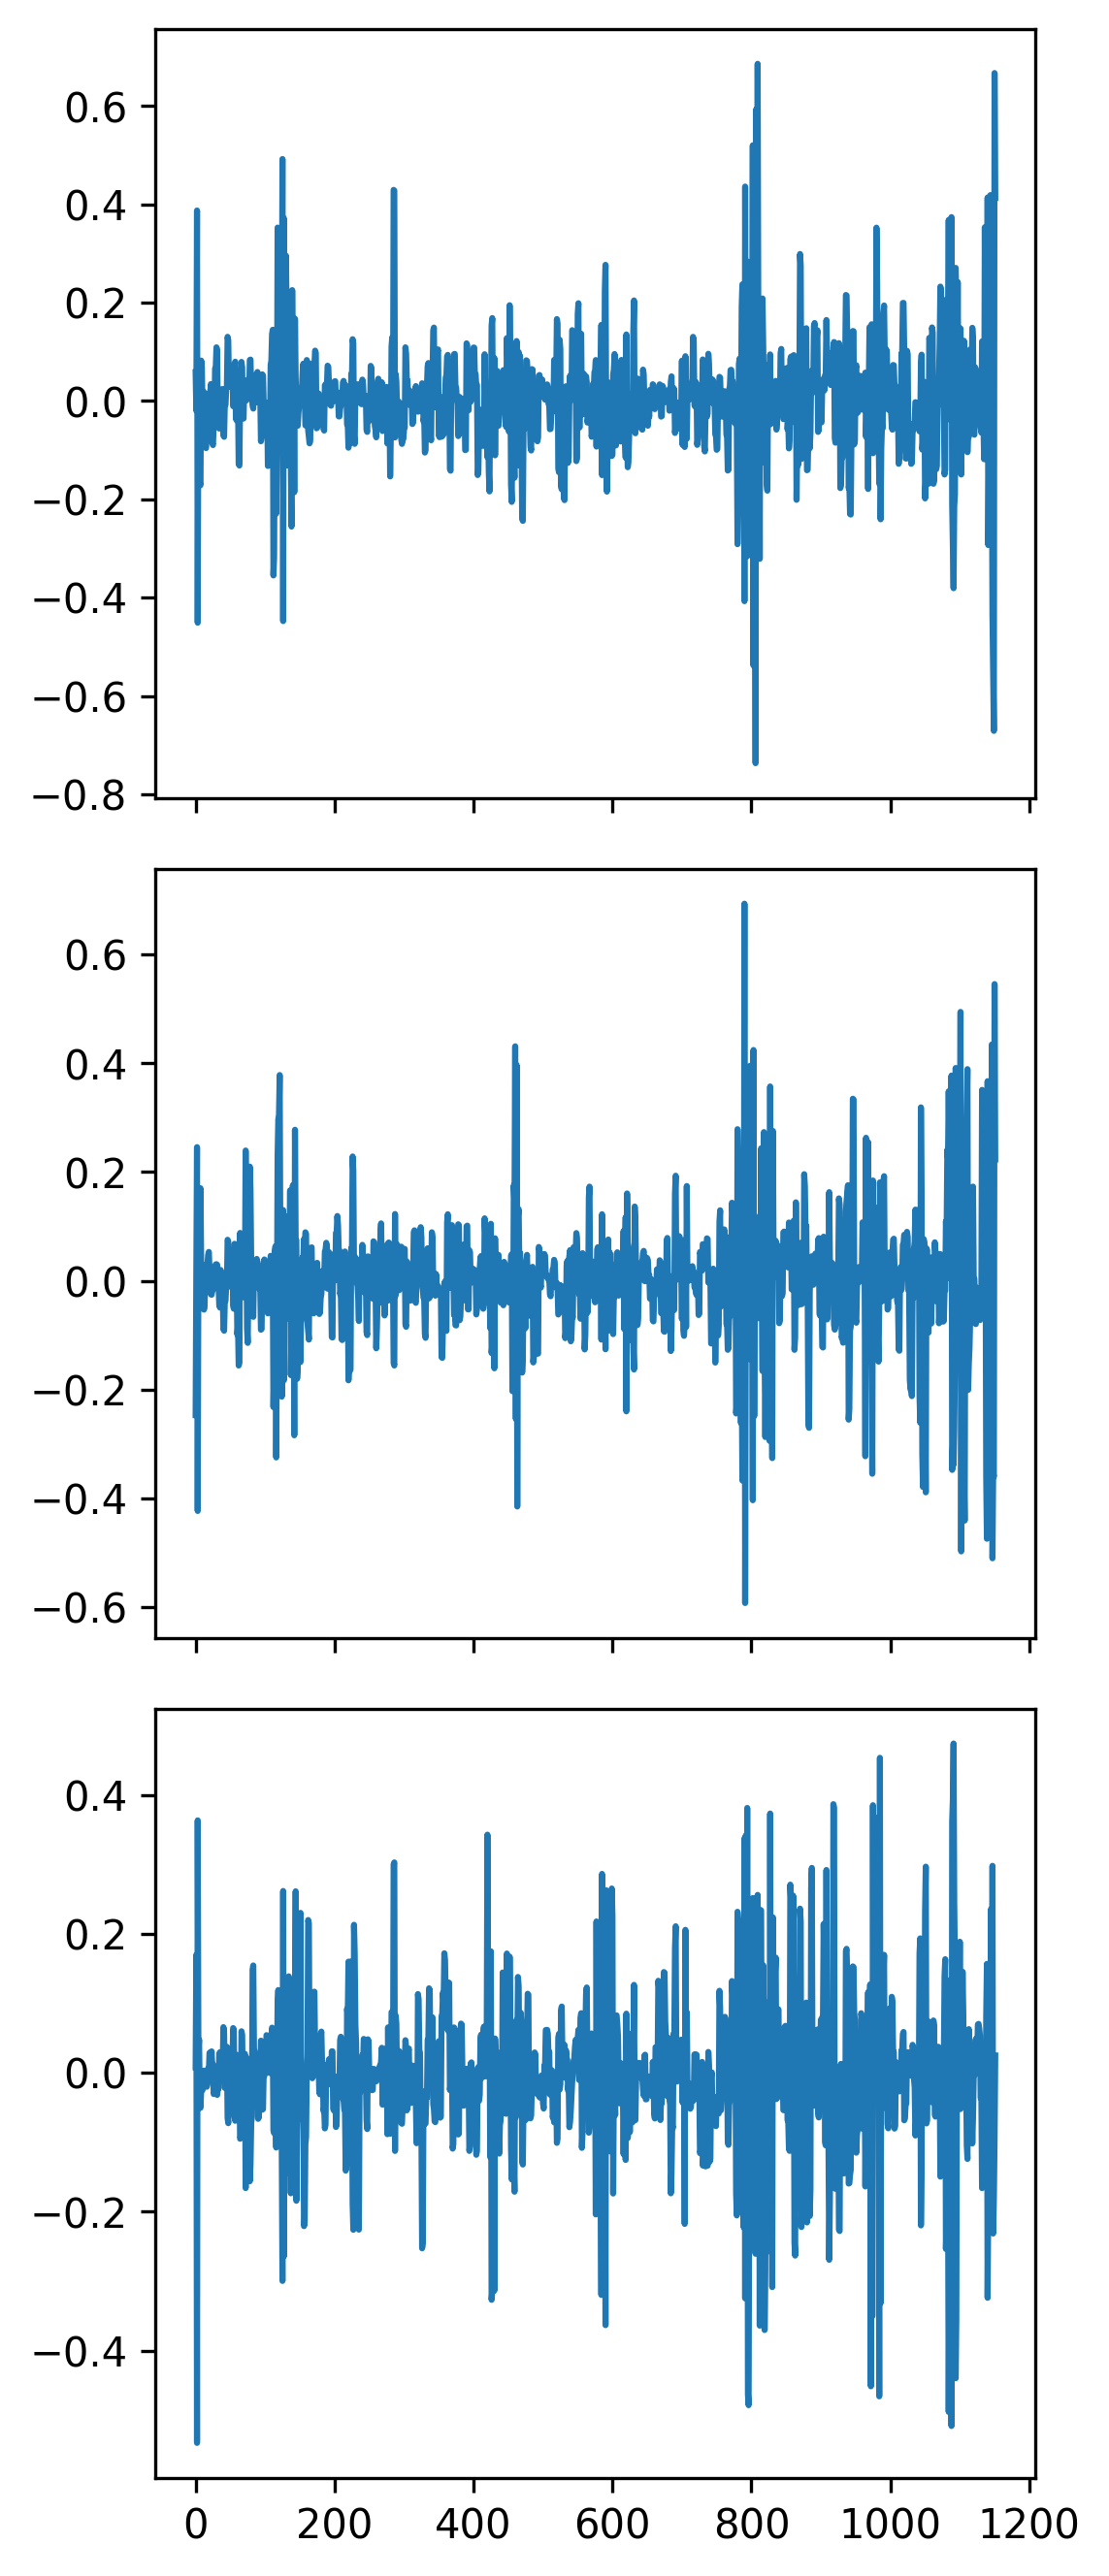

In [ ]:
pca_features(pca_g, rho_g_tmr_feat['bb-torsions'].describe(), 3, 0.4)

In [ ]:
sort_traj_along_pc(rho_g_tmr_data['bb-torsions'], pca_g, start_frame, 
                   root_dir+"traj/rhodopsin_gibound_receptor.gro", 
                   root_dir+"traj/rhodopsin_gibound_receptor.xtc", 
                   root_dir+"pca/rhodopsin_gibound_receptor_by_tmr", num_pc=3)

## Clustering

To identify important states of an ensemble, we can use clustering algorithms. Here we show how to cluster a combined ensemble from two simulations into two clusters using k-means clustering. The plot shows how many frames from which simulation were sorted in which cluster.

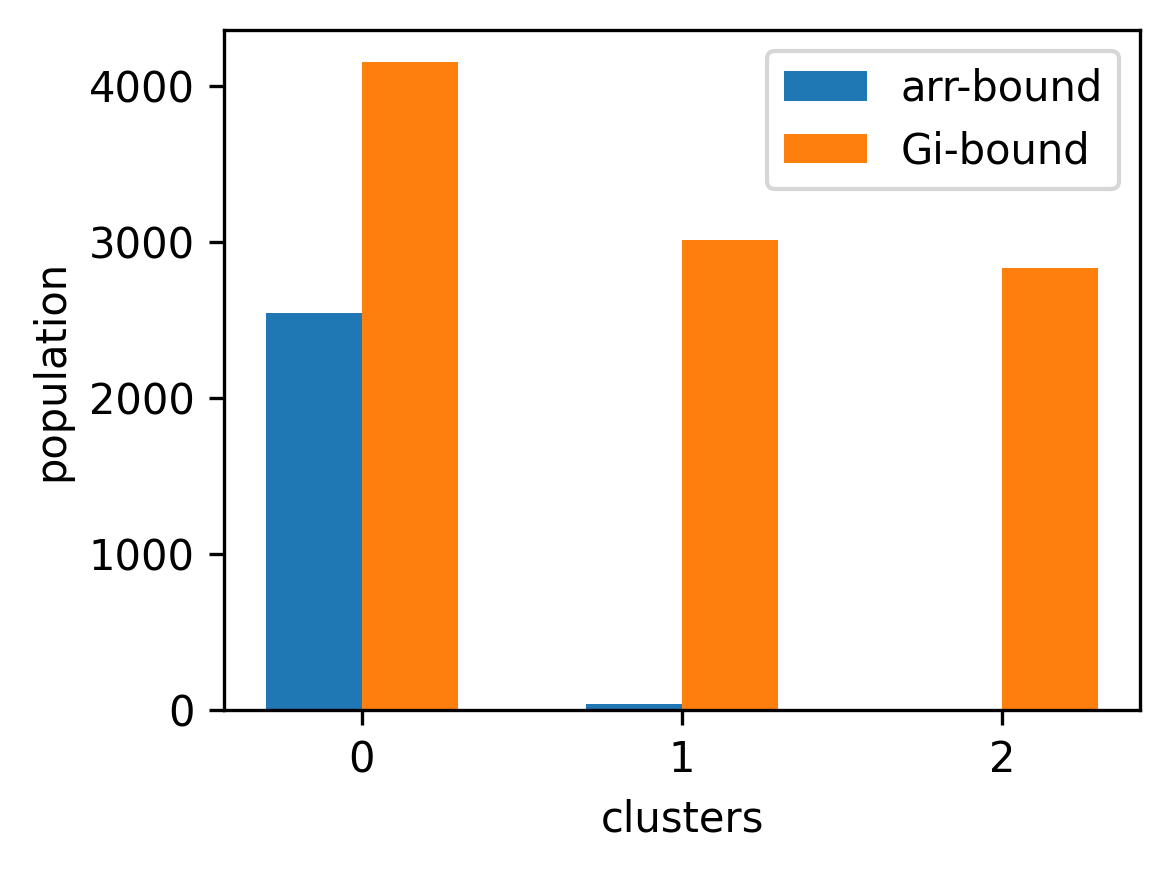

In [ ]:
cc = obtain_combined_clusters(rho_a_tmr_data['bb-torsions'],rho_g_tmr_data['bb-torsions'],
                              label_a='arr-bound', label_b='Gi-bound', start_frame=0,
                              algorithm='kmeans', max_iter=100, num_clusters=3, min_dist=12,
                              saveas=root_dir+'plots/combined_clust_bbtors.pdf')
cidx, cond, oidx, wss, centroids = cc

In [ ]:
np.savetxt(root_dir+'results/combined-cluster-indices.csv', 
           np.array([cidx, cond, oidx], dtype=int).T,
           delimiter=',', fmt='%i',
           header='Cluster, Condition, Index within condition')

We can sort the frames from each ensemble into these clusters, writing them as separate trajectory files. As with pricipal components, we can look at them using VMD.

In [ ]:
name = "rhodopsin_gibound_tm"
write_cluster_traj(cidx[cond==0], root_dir+"traj/"+name+".gro",root_dir+"traj/"+name+".xtc", 
                   root_dir+"clusters/"+"combined_clust_bbtors_"+name, start_frame )

name = "rhodopsin_arrbound_tm"
write_cluster_traj(cidx[cond==0], root_dir+"traj/"+name+".gro",root_dir+"traj/"+name+".xtc", 
                   root_dir+"clusters/"+"combined_clust_bbtors_"+name, start_frame )

Number of frames in trajectory: 4587
Number of cluster indices: 10000
Number of frames in trajectory: 12000
Number of cluster indices: 10000


A common method to obtain the optimal number of clusters is the elbow plot. We plot the with-in-sum-of-squares (WSS) for a few repetitions for an increasing number of clusters.  Then we look for the "elbow" in the resulting plot. Unfortunately, sometimes there is no clear result though.

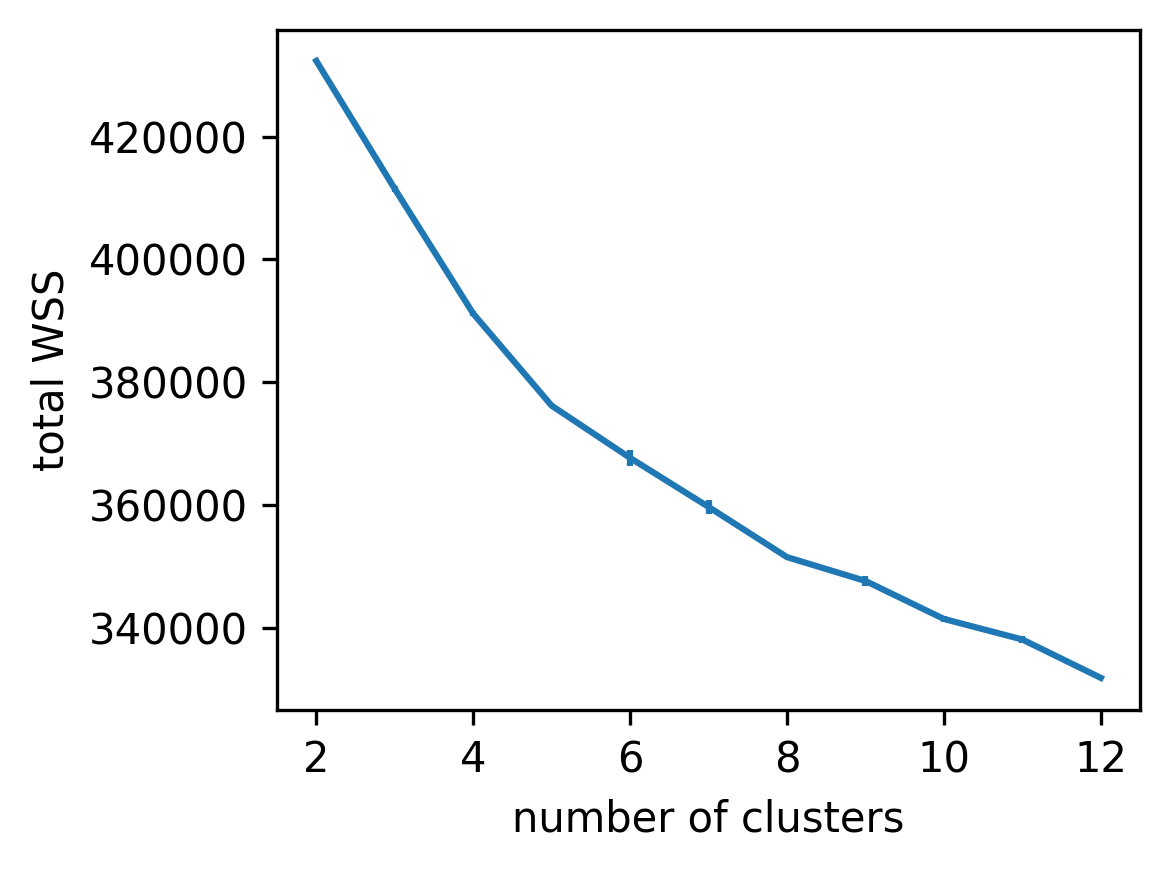

In [ ]:
wss_avg, wss_std = wss_over_number_of_combined_clusters(rho_a_tmr_data['bb-torsions'], 
                                                        rho_g_tmr_data['bb-torsions'],
                                                        label_a='arr-bound', label_b='G-bound', 
                                                        start_frame=start_frame,
                                                        algorithm='kmeans', 
                                                        max_iter=100, num_repeats = 5, 
                                                        max_num_clusters = 12, 
                                                        plot_file = None)

Of course, we can also cluster a single simulation

Number of frames in trajectory: 4587
Number of cluster indices: 2587


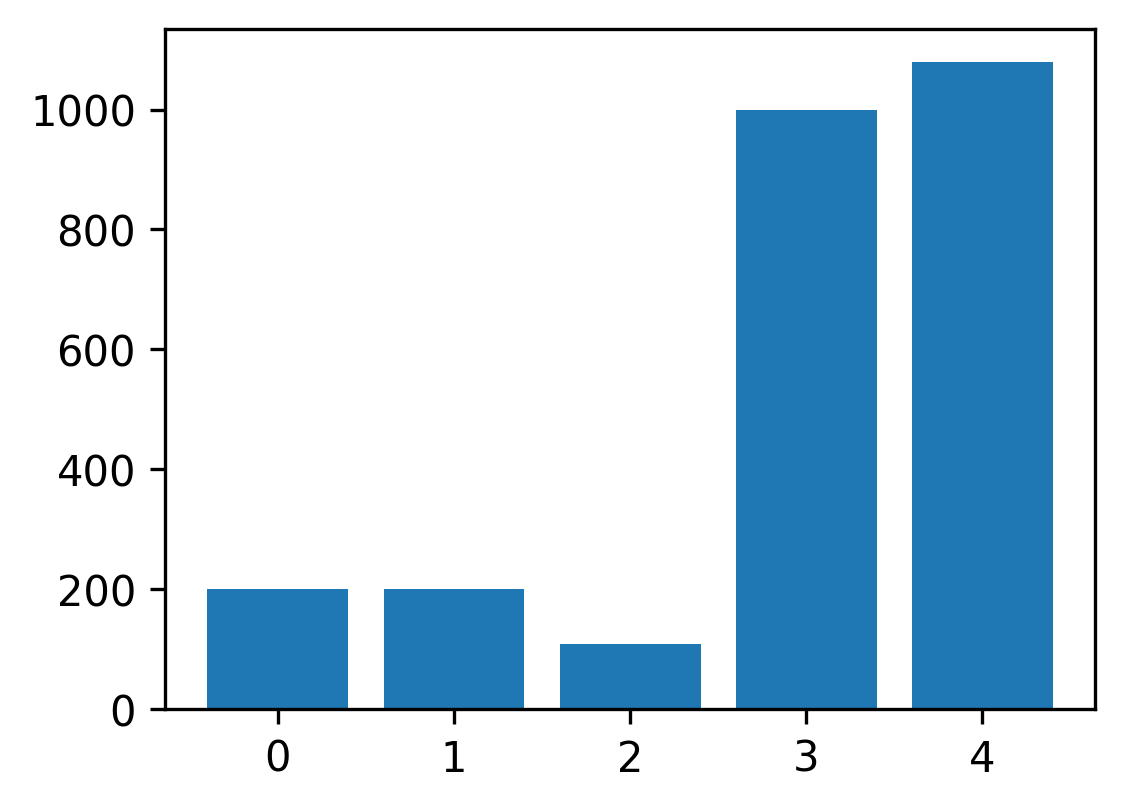

In [ ]:
_ci, _wss, _centroids = obtain_clusters( rho_g_tmr_data['bb-torsions'], num_clusters=5 )
name = "rhodopsin_gibound_tm"
write_cluster_traj( _ci, root_dir+"traj/"+name+".gro",root_dir+"traj/"+name+".xtc", 
                   root_dir+"clusters/"+"clust_bbtors_"+name, start_frame )

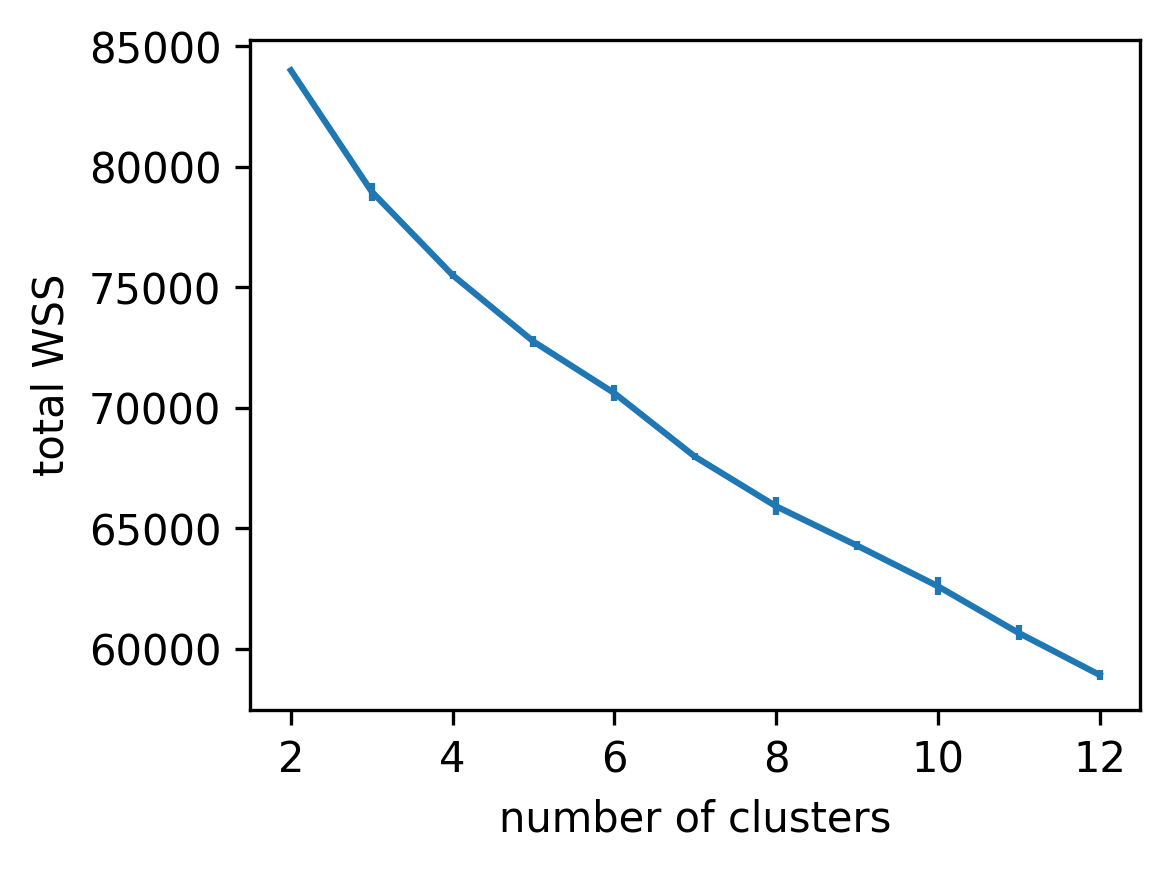

In [ ]:
wss_avg, wss_std = wss_over_number_of_clusters(rho_g_tmr_data['bb-torsions'],
                                               algorithm='kmeans', 
                                               max_iter=100, num_repeats = 5, 
                                               max_num_clusters = 12, 
                                               plot_file = None)